# Sales data analysis across various walmart stores


###Goals:
Walmart is one of the world's largest retailers, and precise sales estimates in many areas are critical for them. Because there are several elements that might influence sales in each department, it is critical that we identify the important aspects that influence sales and utilize them to construct a model that will assist in accurately projecting sales.

###About the data
Our dataset consists of walmart stores and their features. This dataset contains columns like type of store, store size along with its features like temperature, fuel price, etc. Basically, we have weekly sales data for 45 stores and 99 departments for a period of 3 years. We have performed analysis to find answers to the questions like products of which category have highest number of sales? how can we forecast the sales for a store? 

##Readme

Steps to run the project:

1) Please store all the csv files (test.csv, train.csv, features.csv and stores.csv) and ipynb files in the same folder.

2) Please run the following command,
pip3 install pyspark
pip3 install pixiedust
pip3 install matplotlib
pip3 install seaborn

3) Please click on run-all cells option and it takes about 10 mins to run the entire file and to plot all the visualizations in it.

Project submitted by:

Raj Patil (825897040) and Swanand Barsawade (825876097)

## Importing libraries

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, quarter, dayofmonth, dayofyear, weekofyear,when, col, log
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler,RegexTokenizer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession \
    .builder \
    .getOrCreate()

# import pixiedust for displaying dataframes and schemas
import pixiedust
pixiedust.optOut() # disable data sharing

# import matplotlib for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn for data visualization
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# import pandas and numpy
import pandas as pd
import numpy as np

# import warnings to avoid warning
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/11 20:16:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Pixiedust database opened successfully


Pixiedust will not collect anonymous install statistics.


## Loading the data

In [ ]:
features_data = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("features.csv")
stores_data = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("stores.csv")
train_data = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("train.csv")
test_data = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("test.csv")

## Data Preprocessing

After observing the datasets, we can see that it's hard to work with each csv file seperately and so we decided to merge it into one dataframe so that preprocessing becomes easy. We have changed the schema of variables to make the dataset uniform as it is required to do so while using spark.
Also, we have added columns like Year, Quarter, Month, Week, and Day so that it's easy to carry out analysis.

In [1]:
# Merge features, store and train data sets to create dataframe df
train_stores = train_data.join(stores_data, on=['store'], how='left_outer')
features_train_stores = train_stores.join(features_data, on=['store', 'Date', 'IsHoliday'], how='left_outer')

NameError: ignored

In [2]:
# Merge features, store and test data sets to create dataframe test_df
test_stores = test_data.join(stores_data, on=['store'], how='left_outer')
features_test_stores = test_stores.join(features_data, on=['store', 'Date', 'IsHoliday'], how='left_outer')

NameError: ignored

In [ ]:
# Change schema of variables

features_train_stores = features_train_stores.withColumn("CPI", features_train_stores["CPI"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("Unemployment", features_train_stores["Unemployment"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("MarkDown1", features_train_stores["MarkDown1"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("MarkDown2", features_train_stores["MarkDown2"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("MarkDown3", features_train_stores["MarkDown3"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("MarkDown4", features_train_stores["MarkDown4"].cast(DoubleType()))
features_train_stores = features_train_stores.withColumn("MarkDown5", features_train_stores["MarkDown5"].cast(DoubleType()))

features_test_stores = features_test_stores.withColumn("CPI", features_test_stores["CPI"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("Unemployment", features_test_stores["Unemployment"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("MarkDown1", features_test_stores["MarkDown1"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("MarkDown2", features_test_stores["MarkDown2"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("MarkDown3", features_test_stores["MarkDown3"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("MarkDown4", features_test_stores["MarkDown4"].cast(DoubleType()))
features_test_stores = features_test_stores.withColumn("MarkDown5", features_test_stores["MarkDown5"].cast(DoubleType()))

In [ ]:
# Add new variables (features) - Year, Quarter, Month, Week, Day_of_month and Day_of_year

features_train_stores = features_train_stores.withColumn('Year',year(features_train_stores.Date))
features_train_stores = features_train_stores.withColumn('Quarter',quarter(features_train_stores.Date))
features_train_stores = features_train_stores.withColumn('Month',month(features_train_stores.Date))
features_train_stores = features_train_stores.withColumn('Week',weekofyear(features_train_stores.Date))
features_train_stores = features_train_stores.withColumn('Day_of_month',dayofmonth(features_train_stores.Date))
features_train_stores = features_train_stores.withColumn('Day_of_year',dayofyear(features_train_stores.Date))

features_test_stores  = features_test_stores .withColumn('Year',year(features_test_stores .Date))
features_test_stores  = features_test_stores .withColumn('Quarter',quarter(features_test_stores .Date))
features_test_stores  = features_test_stores .withColumn('Month',month(features_test_stores .Date))
features_test_stores  = features_test_stores .withColumn('Week',weekofyear(features_test_stores .Date))
features_test_stores  = features_test_stores .withColumn('Day_of_month',dayofmonth(features_test_stores .Date))
features_test_stores  = features_test_stores .withColumn('Day_of_year',dayofyear(features_test_stores .Date))

## Data Exploration

In data exploration, we have observed certain inferences about the datasets. These inferences help us understand more about the data in depth like how many types of stores are there, how many departments are there, which type of store has the highest sales, comparing sizes of stores, observing corelated features, etc.

In [ ]:
# Check how many years data set contains
features_train_stores.select('Year').distinct().orderBy('Year',ascending=True).show(features_train_stores.count(), False)

+----+
|Year|
+----+
|2010|
|2011|
|2012|
+----+



<p style="background:palegreen;color:black">
    <b>Inference 1-</b> We have the data for 3 years i.e 2010,2011,2012.
</p>

In [ ]:
# Check how many types of stores are in the data set
features_train_stores.select('Type').distinct().orderBy('Type').show(features_train_stores.count(), False)

+----+
|Type|
+----+
|A   |
|B   |
|C   |
+----+



<p style="background:palegreen;color:black">
<b>Inference 2-</b> There are 3 type of stores i.e A,B,C.</p>

In [ ]:
# Check how many stores data set contains
features_train_stores.select('store').distinct().orderBy('store',ascending=True).show(features_train_stores.count(), truncate=False)

+-----+
|store|
+-----+
|1    |
|2    |
|3    |
|4    |
|5    |
|6    |
|7    |
|8    |
|9    |
|10   |
|11   |
|12   |
|13   |
|14   |
|15   |
|16   |
|17   |
|18   |
|19   |
|20   |
|21   |
|22   |
|23   |
|24   |
|25   |
|26   |
|27   |
|28   |
|29   |
|30   |
|31   |
|32   |
|33   |
|34   |
|35   |
|36   |
|37   |
|38   |
|39   |
|40   |
|41   |
|42   |
|43   |
|44   |
|45   |
+-----+



<p style="background:palegreen;color:black">
<b>Inference 3-</b> The data is available for 45 stores in total.
</p>

In [ ]:
# Check how many departments are in the data set
features_train_stores.select('Dept').distinct().orderBy('Dept').show(features_train_stores.count(), False)

+----+
|Dept|
+----+
|1   |
|2   |
|3   |
|4   |
|5   |
|6   |
|7   |
|8   |
|9   |
|10  |
|11  |
|12  |
|13  |
|14  |
|16  |
|17  |
|18  |
|19  |
|20  |
|21  |
|22  |
|23  |
|24  |
|25  |
|26  |
|27  |
|28  |
|29  |
|30  |
|31  |
|32  |
|33  |
|34  |
|35  |
|36  |
|37  |
|38  |
|39  |
|40  |
|41  |
|42  |
|43  |
|44  |
|45  |
|46  |
|47  |
|48  |
|49  |
|50  |
|51  |
|52  |
|54  |
|55  |
|56  |
|58  |
|59  |
|60  |
|65  |
|67  |
|71  |
|72  |
|74  |
|77  |
|78  |
|79  |
|80  |
|81  |
|82  |
|83  |
|85  |
|87  |
|90  |
|91  |
|92  |
|93  |
|94  |
|95  |
|96  |
|97  |
|98  |
|99  |
+----+



<p style="background:palegreen;color:black">
<b>Inference 4-</b> We can observe that there are 99 departments in total.
</p>

Text(0, 0.5, 'Number of Stores')

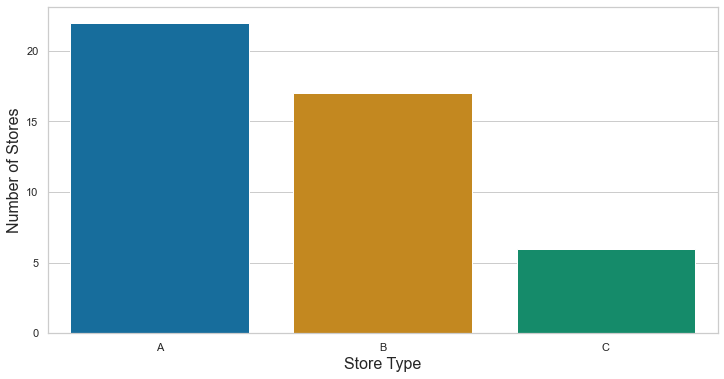

In [ ]:
# Convert stores data set (Spark data frame) to Pandas data frame for visualization
stores_data_pd = stores_data.toPandas()
# Check the number of stores for each store type
plt.figure(figsize=(12,6))
sns.barplot(stores_data_pd['Type'].unique(), stores_data_pd['Size'].groupby(stores_data_pd['Type']).count())
plt.xlabel('Store Type', fontsize=16)
plt.ylabel('Number of Stores', fontsize=16)

<p style="background:palegreen;color:black">
<b>Inference 5-</b> There are more number of stores of type A as compared to type B and C stores.
</p>

Text(0, 0.5, 'Store Size')

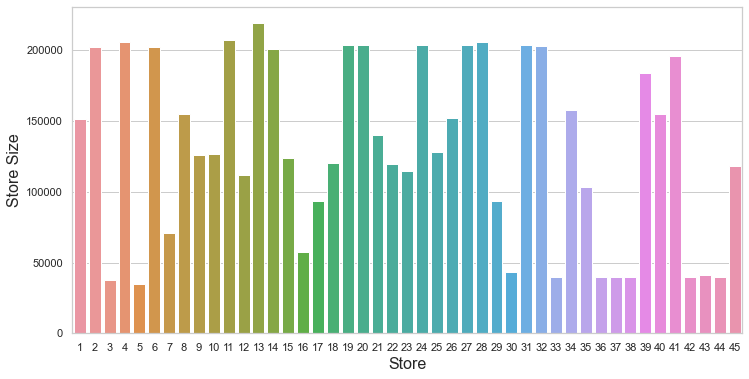

In [ ]:
# Check store size of each store
plt.figure(figsize=(12,6))
sns.barplot(stores_data_pd['Store'], stores_data_pd['Size'])
plt.xlabel('Store', fontsize=16)
plt.ylabel('Store Size', fontsize=16)

<p style="background:palegreen;color:black">
<b>Inference 6-</b> We can observe that majority of stores have a size greater than 100,000 sqft.
</p>

Text(0, 0.5, 'Store Size')

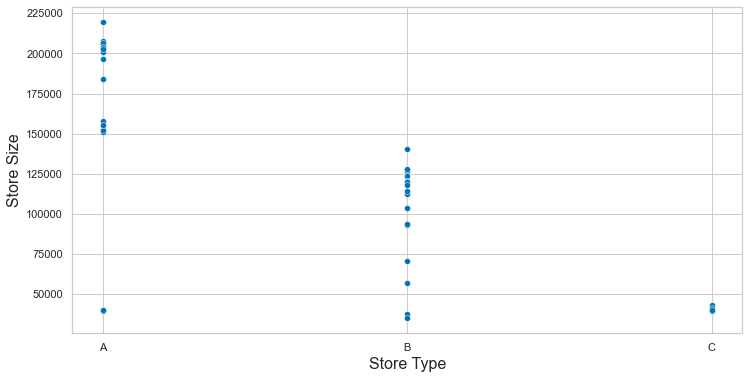

In [ ]:
# Check store sizes for each store type
plt.figure(figsize=(12,6))
sns.scatterplot(stores_data_pd['Type'], stores_data_pd['Size'])
plt.xlabel('Store Type', fontsize=16)
plt.ylabel('Store Size', fontsize=16)

<p style="background:palegreen;color:black">
<b>Inference 7-</b> Store type A are the largest stores and bigger than store type B and C. We can also observe that there is one outlier in type A stores as compared to the rest of the stores.
</p>

In [ ]:
# Convert features_train_stores data set (Spark data frame) to Pandas data frame for visualization
features_train_stores_pd = features_train_stores.toPandas()
# Convert features_test_stores data set (Spark data frame) to Pandas data frame for visualization
features_test_stores_pd = features_test_stores.toPandas()

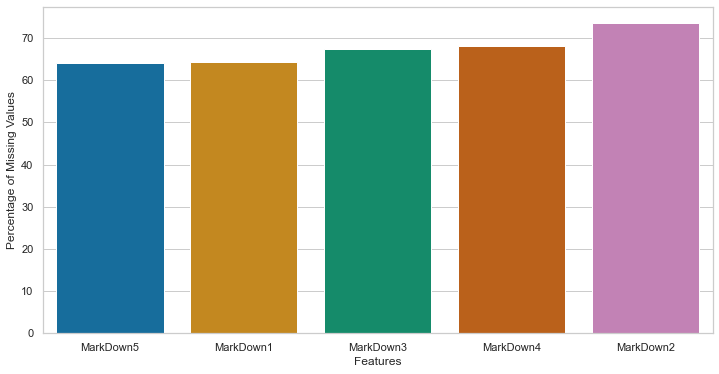

In [ ]:
# Percentage of missing values in training data set
missing_values_train = features_train_stores_pd.isnull().sum() / len(features_train_stores_pd) * 100
missing_values_train = missing_values_train[missing_values_train > 0]
missing_values_train.sort_values(inplace=True)

missing_values_train = missing_values_train.to_frame()
missing_values_train.columns = ['count']
missing_values_train.index.names = ['Name']
missing_values_train['Name'] = missing_values_train.index

f, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x = 'Name', y = 'count', data = missing_values_train)
ax.set(xlabel = 'Features', ylabel = 'Percentage of Missing Values')
plt.show()

<p style="background:palegreen;color:black">
<b>Inference 8-</b> In the train dataset, all the features of Markdown*(1 to 5) have more than 60% missing values.
</p>

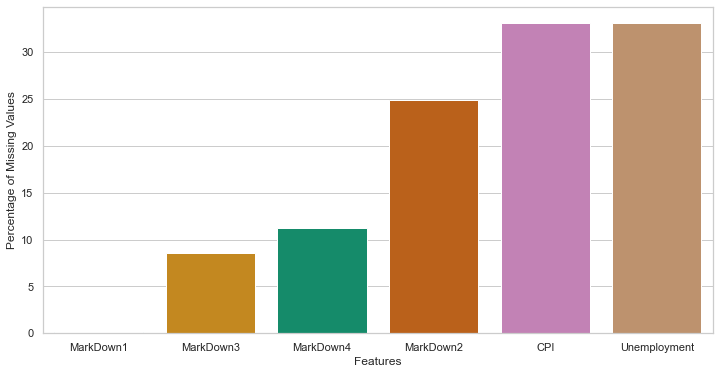

In [ ]:
# Percentage of missing values in test data set
missing_values_test = features_test_stores_pd.isnull().sum() / len(features_test_stores_pd) * 100
missing_values_test = missing_values_test[missing_values_test > 0]
missing_values_test.sort_values(inplace=True)

missing_values_test = missing_values_test.to_frame()
missing_values_test.columns = ['count']
missing_values_test.index.names = ['Name']
missing_values_test['Name'] = missing_values_test.index

f, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x = 'Name', y = 'count', data = missing_values_test)
ax.set(xlabel = 'Features', ylabel = 'Percentage of Missing Values')
plt.show()

<p style="background:palegreen;color:black">
<b>Inference 9-</b> In the test dataset, Markdown1,2,3,4 and CPI,Unemployment features have missing values.
</p>

<AxesSubplot:>

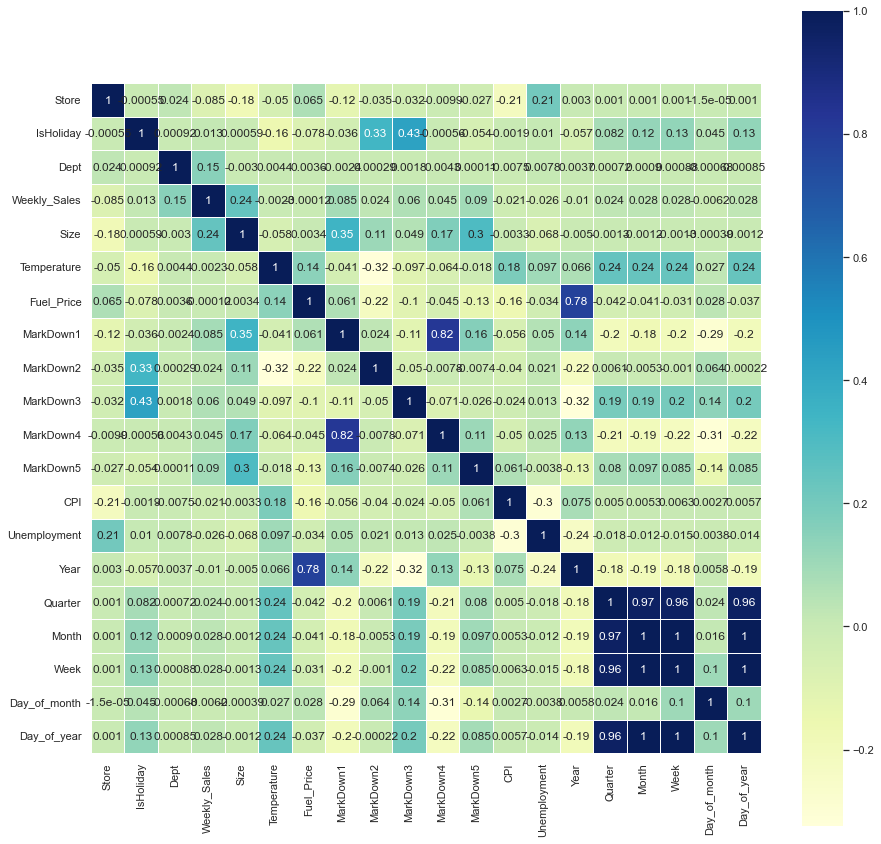

In [ ]:
# Plot Correlation Matrix to identify relationship between variables (features)
corrmat = features_train_stores_pd.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5,cmap="YlGnBu")

<p style="background:palegreen;color:black">
<b>Inference 10-</b> The features 'Markdown1' and 'Markdown4' are corelated. Similarly,the features 'Year' and 'Fuel_Price' are corelated.
</p>

## Data Visualization

In order to get some inferences, it was requied to do more in-depth analysis of the data, so we visualised it using lineplots, catplots, barplots and heatmaps. We were able to understand how factors like holidays affect the sales, which departments have the highest sales in a given store, etc. 

Text(0.5, 1.0, 'Weekly sales for every type of store')

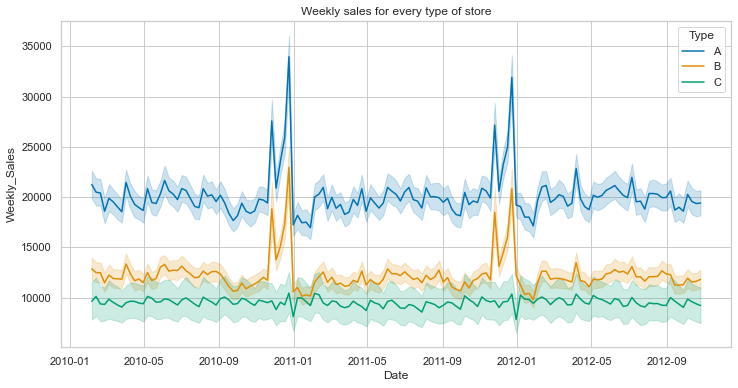

In [ ]:
# Visualizing trend of weekly sales by store type
dates = pd.to_datetime(features_train_stores_pd['Date'], format = '%Y-%m-%d')
plt.figure(figsize=(12,6))
sns.lineplot(x = dates, y = "Weekly_Sales", hue = "Type", data = features_train_stores_pd).set_title('Weekly sales for every type of store')

<p style="background:palegreen;color:black">
<b>Inference 11-</b> Store type A has the highest weekly sales followed by type B and type C respectively. It may be because type A stores are bigger and more in number.
</p>

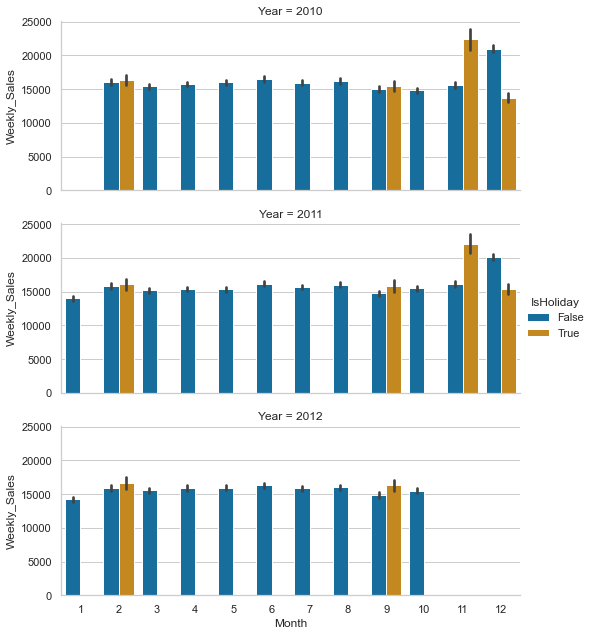

In [ ]:
# Comparison of weekly sales per month based on holiday
graph1 = sns.catplot(x="Month", y="Weekly_Sales",
                hue="IsHoliday", row="Year",
                data=features_train_stores_pd, kind="bar",
                height=3, aspect=2.5);

<p style="background:palegreen;color:black">
<b>Inference 12-</b> We can observe holidays in the month of February,September,November and December. Also, we can note the highest weekly sales in the month of November in 2011.
</p>

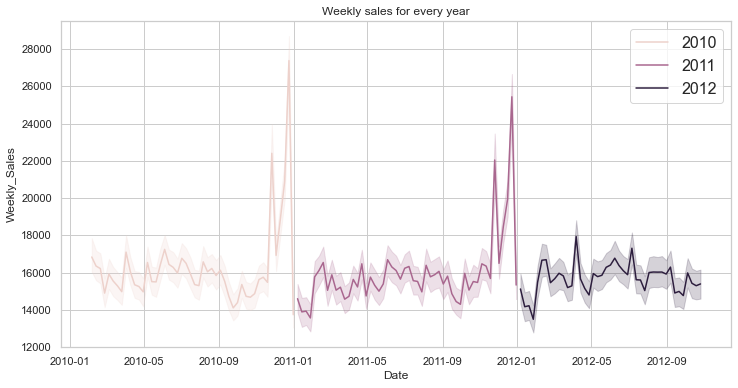

In [ ]:
# Visualizing trend of weekly sales by store type
plt.figure(figsize=(12,6))
sns.lineplot(x=dates, y='Weekly_Sales', hue = "Year", data=features_train_stores_pd).set_title('Weekly sales for every year')
# set axes labels
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)


<p style="background:palegreen;color:black">
<b>Inference 13-</b> Peaks in the sales are obsereved at the end of every year. The sales might have increased due to holiday season in the month of November and December.
</p>

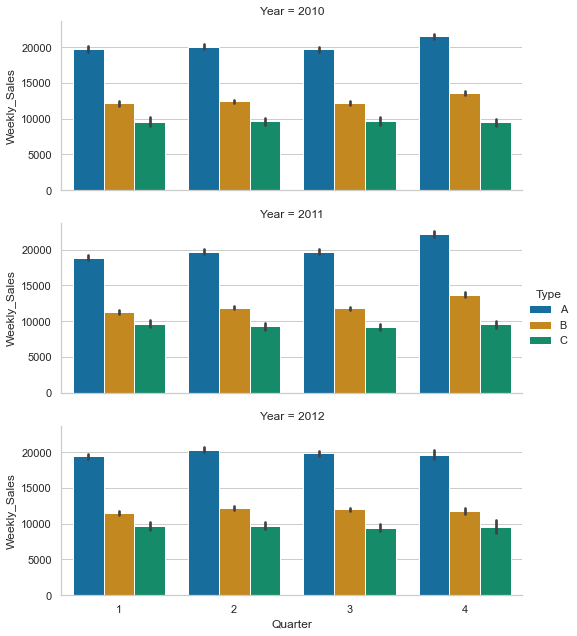

In [ ]:
# Weekly sales per quarter by store type
graph2 = sns.catplot(x="Quarter", y="Weekly_Sales",
                hue="Type", row="Year",
                data=features_train_stores_pd, kind="bar",
                height=3, aspect=2.5);

<p style="background:palegreen;color:black">
<b>Inference 14-</b> Store type A has the highest weekly sales throughtout the year followed by store type B and C.
</p>

<AxesSubplot:xlabel='Dept', ylabel='Weekly_Sales'>

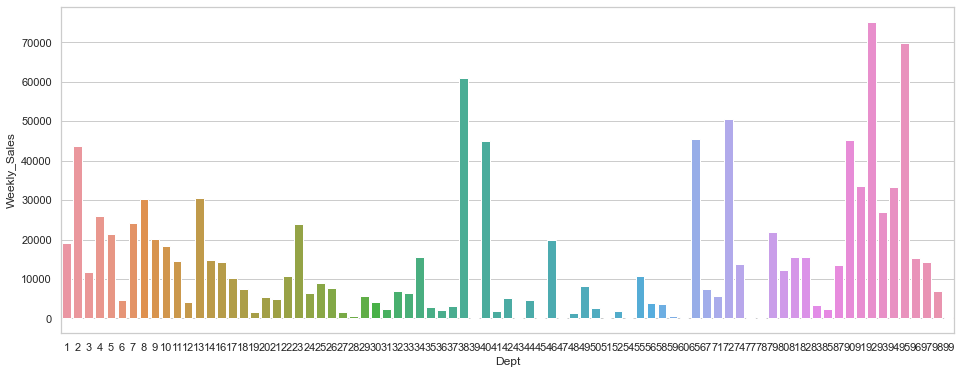

In [ ]:
# Weekly sales per department
plt.figure(figsize=(16,6))
sns.barplot(x = "Dept", y = "Weekly_Sales", ci=None, data = features_train_stores_pd)

<p style="background:palegreen;color:black">
<b>Inference 15-</b> The departments are numbered so we can not identify them but we can observe that department 38,72,92,95 have high weekly sales as compared to the rest of the departments and departments 39,43,45,47,51,54,60,77,78 have very low or no sales.
</p>

###Dealing with Null values in training and test datasets.

We observed null values in certain columns like markdown, so we replaced them with mean values. We also fixed all the other anomalies that present in the dataset.

<AxesSubplot:>

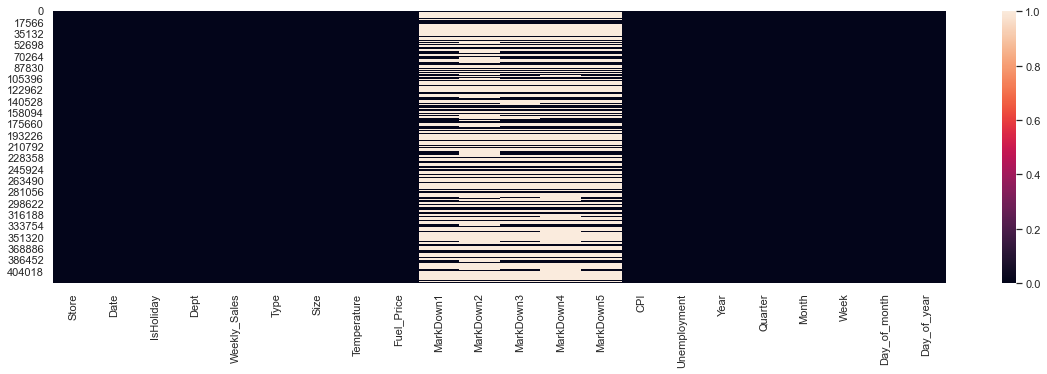

In [ ]:
# Plot heat maps to visually identify missing values in training (df) and test (test_df) data sets
plt.figure(figsize=(20,5))
sns.heatmap(features_train_stores_pd.isnull())

<p style="background:palegreen;color:black">
<b>Inference 15-</b> It is seen that in the training dataframe, the features Markdown1,Markdown2,Markdown3,Markdown4,Markdown5 have null values. We will handle these null values in the later phase.
</p>

<AxesSubplot:>

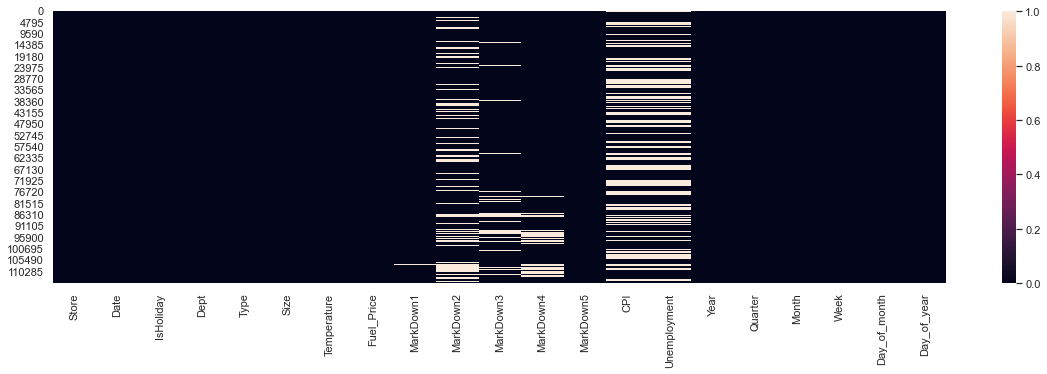

In [ ]:
## heat map of test data set
plt.figure(figsize=(20,5))
sns.heatmap(features_test_stores_pd.isnull())

<p style="background:palegreen;color:black">
<b>Inference 16-</b> It is seen that in the test dataframe, the features Markdown1,Markdown2,Markdown3,Markdown4,CPI and Unemployment have null values. We will handle these null values in the later phase.
</p>

In [ ]:
# Imputing missing values using column means
imputer = Imputer(
    inputCols=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], 
    outputCols=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
)
features_train_stores = imputer.setStrategy("mean").fit(features_train_stores).transform(features_train_stores)
features_test_stores = imputer.setStrategy("mean").fit(features_test_stores).transform(features_test_stores)

In [ ]:
# Look for other anomalies in data
display(features_train_stores.describe())

summary,Store,IsHoliday,Dept,label,Type,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Year,Week
count,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570
mean,22.200545579619043,0.07035842208885831,44.26031738501317,8.501063202662296,None,136727.91573878596,60.09005873283215,8.633402164889665,7.419603290856289,6.022818005780404,8.305171800002702,171.20194682295747,7.960288694641632,2010.9685912185403,25.826761866356716
stddev,12.785297389902782,0.25575040505152413,30.492054015786017,2.0744864629857025,None,60980.58332810143,18.447931147616114,0.9916876593901996,1.7658294926917828,2.1699980541685657,0.5446898005501988,39.159275623012874,1.8632960384301653,0.7968760186996942,14.15188689935623
min,1,0,1,0.0,A,34875,-2.06,0.23901690047049992,0.0,0.0,4.913830664825064,126.064,3.879,2010,1
max,45,1,99,13.44893008731151,C,219622,100.14,11.392426043275613,11.557138886096519,11.860984669791929,11.594692346939093,227.2328068,14.313,2012,52


In [ ]:
# Look for other anomalies in data
display(features_test_stores.describe())

summary,Store,IsHoliday,Dept,Type,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Year,Week
count,115064,115064,115064,115064,115064,115064,115064,115064,115064,115064,115064,115064,115064,115064
mean,22.2382065633039,0.07759160119585622,44.33952409094069,None,136497.68892094833,53.94180386567838,8.185095077770969,6.861900716048489,4.590643501262064,7.755916887452153,176.9613466485956,6.868733166881883,2012.7671817423347,23.05096294236251
stddev,12.809929591378935,0.26752900148720504,30.656410130030174,None,61106.926438169576,18.724152888948137,1.5244428082597654,2.1145134182831176,2.326080182461024,0.9320348794020639,33.71447894171288,1.2944828170873803,0.4226292333441719,15.75040714665268
min,1,0,1,A,34875,-7.29,0.0,0.0,0.0,0.0,131.2362258,3.684,2012,1
max,45,1,99,C,219622,101.95,11.544288270087605,11.171493328355947,11.914946716472484,13.556025973236231,228.9764563,10.199,2013,52


<p style="background:palegreen;color:black">
<b>Inference 17-</b> Notice that the min value for few features is less than 0 so replace them with 0.
</p>

In [ ]:
features_train_stores = features_train_stores.withColumn("Weekly_Sales", when(col("Weekly_Sales") >= 0, col("Weekly_Sales")).otherwise(0))
features_train_stores = features_train_stores.withColumn("MarkDown2", when(col("MarkDown2") >= 0, col("MarkDown2")).otherwise(0))
features_train_stores = features_train_stores.withColumn("MarkDown3", when(col("MarkDown3") >= 0, col("MarkDown3")).otherwise(0))

In [ ]:
features_test_stores = features_test_stores.withColumn("MarkDown1", when(col("MarkDown1") >= 0, col("MarkDown1")).otherwise(0))
features_test_stores = features_test_stores.withColumn("MarkDown2", when(col("MarkDown2") >= 0, col("MarkDown2")).otherwise(0))
features_test_stores = features_test_stores.withColumn("MarkDown3", when(col("MarkDown3") >= 0, col("MarkDown3")).otherwise(0))
features_test_stores = features_test_stores.withColumn("MarkDown5", when(col("MarkDown5") >= 0, col("MarkDown5")).otherwise(0))

## Feature Transformation

In [ ]:
# Change schema of variables and dropping unwanted columns
features_train_stores = features_train_stores.withColumn("IsHoliday", features_train_stores["IsHoliday"].cast(IntegerType()))
features_test_stores = features_test_stores.withColumn("IsHoliday", features_test_stores["IsHoliday"].cast(IntegerType()))
features_train_stores = features_train_stores.drop('Day_of_month', 'Quarter', 'Day_of_year', 'Month')
features_test_stores = features_test_stores.drop('Day_of_month', 'Quarter', 'Day_of_year', 'Month')

In [ ]:
# Transforming skewed features using log transformation
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for c in skewed:
    features_train_stores = features_train_stores.withColumn(c, log(col(c)+1))
    features_test_stores = features_test_stores.withColumn(c, log(col(c)+1))
    
features_train_stores = features_train_stores.withColumn('Weekly_Sales', log(col('Weekly_Sales')+1))

<p style="background:palegreen;color:black">
<b>Inference 18-</b> From <u>Inference 10</u>, we know 'Year' and 'Fuel_Price' are corelated so we drop 'Fuel_Price' because we use 'Year' to differentiate between different weeks for stores and dept. 'Markdown1' and 'Markdown4' are also corelated so we drop 'Markdown4'. 
</p>

In [ ]:
features_test_stores = features_test_stores.drop('MarkDown4', 'Fuel_Price')
features_train_stores = features_train_stores.drop('MarkDown4', 'Fuel_Price')

## Indexing, Encoding and Scaling

Preparing the linear regression model to predict the weekly sales

In [ ]:
# Rename Weekly_Sales column to label to makes it easy to use with Linear Regression model
features_train_stores = features_train_stores.withColumnRenamed("Weekly_Sales","label")

In [ ]:
# Drop feature Date
features_train_stores = features_train_stores.drop('Date')
features_test_stores = features_test_stores.drop('Date')

In [ ]:
# Split data into train and validate sets
(train_df, validate_df) = features_train_stores.randomSplit([0.8, 0.2])

In [ ]:
#Defining the variables used for training the model  
all_vars = train_df.columns
cat_vars = ['Store', 'Dept', 'IsHoliday', 'Type']
target_value = 'label'
cont_vars = [x for x in all_vars if x not in cat_vars]
cont_vars = [x for x in cont_vars if x not in target_value]

In [ ]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in cat_vars ]

encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

In [ ]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + cont_vars, outputCol="features")

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledfeatures")

In [ ]:
# Train a linear regression model
lr = LinearRegression(labelCol="label", featuresCol="scaledfeatures", maxIter=10, regParam=0.1, elasticNetParam=0.5)

In [ ]:
# chain indexer, encoder, assembler, scaler and linear regression in a pipeline
pipeline = Pipeline(stages = indexers + encoders + [assembler, scaler, lr])

In [ ]:
# fit linear regression model on training data
LR_model = pipeline.fit(train_df)

22/05/11 20:18:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/05/11 20:18:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/11 20:18:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [ ]:
#Using transform in spark to predcit the values
LR_prediction = LR_model.transform(validate_df)

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [ ]:
rmse_LR = evaluator.evaluate(LR_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_LR)

Root Mean Squared Error (RMSE) on test data = 1.28471


In [ ]:
#Putting values in select and predicting 
LR_Predict_train2 = LR_prediction.select("Week","features","label","prediction").toPandas()

###Plotting scatterplot and lineplot to visualise the prediction

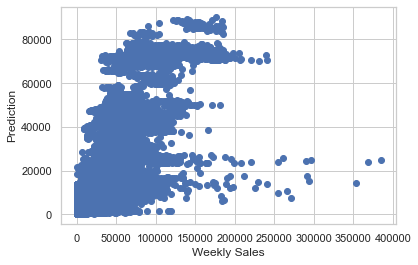

In [ ]:
plt.plot(np.exp(LR_Predict_train2.label)-1, np.exp(LR_Predict_train2.prediction)-1, 'bo')
plt.xlabel('Weekly Sales')
plt.ylabel('Prediction')
plt.show()

<AxesSubplot:xlabel='Week', ylabel='label'>

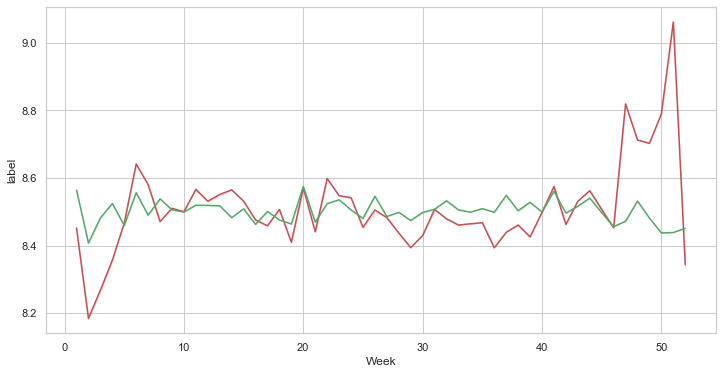

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x = "Week", y = "label", data = LR_Predict_train2, ci=False,color='r')
sns.lineplot(x = "Week", y = "prediction", data = LR_Predict_train2, ci=False,color='g')

We can observe from the above lineplot that our model predicts the sales pretty accurately and aligns with the actual sales.

In [ ]:
LR_prediction.select("prediction","label","features").show()

+-----------------+-----------------+--------------------+
|       prediction|            label|            features|
+-----------------+-----------------+--------------------+
|9.509552046886519|9.584546640264124|(137,[12,68,124,1...|
|9.508725017835197|9.584713082486362|(137,[12,68,124,1...|
|9.508462140743884|9.635382591757711|(137,[12,68,124,1...|
| 9.51019890175166|  9.6657124806772|(137,[12,68,124,1...|
|  9.5081455552767|9.684491015459505|(137,[12,68,124,1...|
|9.521821768302571|9.687873086392374|(137,[12,68,124,1...|
|9.510689211832087|9.693832002776068|(137,[12,68,124,1...|
| 9.51062127730287|9.700742039461112|(137,[12,68,124,1...|
|9.517466890695069|9.715270048755789|(137,[12,68,124,1...|
|9.543528083363094|9.718922080045369|(137,[12,68,124,1...|
|9.511776164299537|9.719481778243786|(137,[12,68,124,1...|
|9.538888851682357|9.722040013677196|(137,[12,68,124,1...|
|9.540169352984615|9.749662486357657|(137,[12,68,124,1...|
| 9.52450483668456|9.788321901039383|(137,[12,68,124,1..

The above table also helps us to observe the predicted values wherein the label column contains the actual weekly sales values and the prediction column contains the predicted values using the same features.

##Conclusion

Company should focus on the inventory management of the store type 'A' as it has the highest sales when compared to other types of stores.

During holidays, the company should focus on certain departments (in this case: 38,72,92,95 departments) as we observe a spike in sales for these departments.

The company should look for ways to recognise issues with departments having less sales and try to figure out ways to increase the sales. They might consider to optimize man power requirements or energy consumption of those departments and utilize it in other departments where it's required more. If they're unable to boost sales in these departments, they should replace it with other departments with higher sales.

The company needs to take into consideration the year end inventory seriously as last two weeks of the year play a vital role in prediction of sales.

Also from inference 10, we observe that Markdowns (promotions, offers, deals, etc) 1,2,3,4 and 5 do not impact the sales and their effect is negligible. The company needs to consider other options in place of markdowns.

It will be helpful to manage inventory after observing analysis of the data and considering the predicted sales values. This increases forecasting capability of the company significantly as well as to optimize their resources to the fullest. This will help the company plan very well ahead of time for holidays too.

